# Symulacja ciągów pseudolosowych, ich filtracja i analiza
1. Symulować szum biały o rozkładzie normlanym N(5, 0.1).
2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną.
3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach.
4. Obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną sygnału wyjściowego. Porównać wyniki z p 2.
Wyniki przedstawiać w postaci tablic oraz wykresów

# Literatura
1. Snopkowski R. Symulacja stochastyczna AGH, Kraków, 2007.
2. Niemiro W. Symulacje stochastyczne i metody Monte Carlo, Uniw. Warszawski, 2013.
3. Cacho K., Bily M., Bukowski J. Random processs, analysis and simulation, 1988
4. Othes R.K., Enochson Analiza numeryczna szeregów czasowych, WNT, Warszawa, 1988

-----------------------------------------

## Importowanie potrzebnych bibliotek

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, describe
import pandas  as pd

## 1. Symulacja szumu białego o rozkładzie normlanym N(5, 0.1).
### Wytworzenie szumu białego o rozkładzie Gassowskim

[5.04531862 4.85586497 4.9527649  4.89751676 4.87471872 5.09096593
 4.96183602 4.92364148 5.05486026 4.93765353 5.22187097 5.18914254
 4.98030074 5.15232934 5.07760218 4.96728359 5.02550766 4.84046502
 4.86329835 4.9709551  4.96679809 5.05644918 4.91210508 5.00637381
 4.87067681 4.95576006 5.02112242 4.9381305  5.19094813 4.8645434
 5.06488146 5.16089079 4.93048032 5.19452526 4.92403497 4.88302814
 4.85115828 5.10286461 4.99408865 4.95610466 5.08976484 4.9815447
 4.92845902 5.15063032 4.93242216 5.08645583 4.94637575 5.10374611
 4.86715661 5.12208054 5.18802381 4.92373605 5.09175528 4.92770061
 5.09086112 4.97976315 5.08660436 5.07291138 4.96101735 4.87550071
 5.04532762 4.94235058 4.95953634 5.06450468 4.88969319 5.03247544
 4.94920194 5.08677416 4.97264924 5.03617237 4.99814005 4.91769017
 4.96789867 5.05245674 5.10809488 4.90619838 4.93743655 5.05885717
 4.99091069 5.01394608 4.89998535 4.85694257 4.96045119 5.08147277
 5.05738294 5.07054477 4.83737602 5.01393088 4.99191676 4.966006

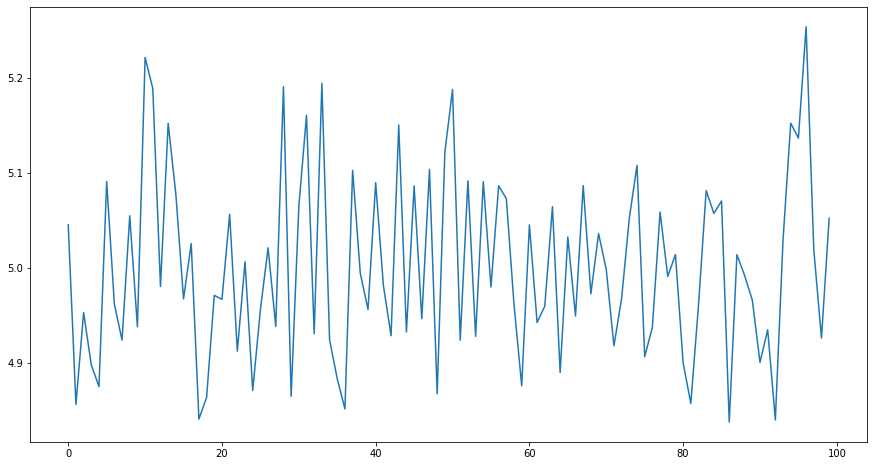

In [220]:
mu = 5
sigma = 0.1
num_samples = 100
samples = np.random.normal(mu, sigma, size=num_samples)

print(samples)

source = {"samples_value": samples}
df= pd.DataFrame(source)

plt.figure(figsize=(15,8))
plt.plot(samples)
plt.show()

Powyższy wygenerowany diagram prezentuje szum biały składającego się z określonej liczby próbek zadeklarowanej w zmiennej <font color=yellow>num_samples</font>. Szum biały jest rodzajem szumu akustycznego, który posiada całkowicie płaskie widmo. W procesie stochastycznym szum biały to ciąg nieskorelowanych zmiennych losowych o zerowej wartości oczekiwanej i stałej wariancji(czyli biały szum to proces kowariancyjnie stacjonarny) oraz w sensie ścisłym to biały szum w którym nieskorelowanie wzmianiamy do niezależności. Biały szum jest tak zwaną ,,cegiełką" podczas konstrukcji procesów stochastycznych. 

### Wyświetlenie histogramu szumu białego o charakterze Gaussowskim

(array([12.,  8., 22., 13., 11., 15.,  8.,  5.,  4.,  2.]),
 array([4.83737602, 4.87906966, 4.92076329, 4.96245693, 5.00415056,
        5.0458442 , 5.08753783, 5.12923147, 5.17092511, 5.21261874,
        5.25431238]),
 <BarContainer object of 10 artists>)

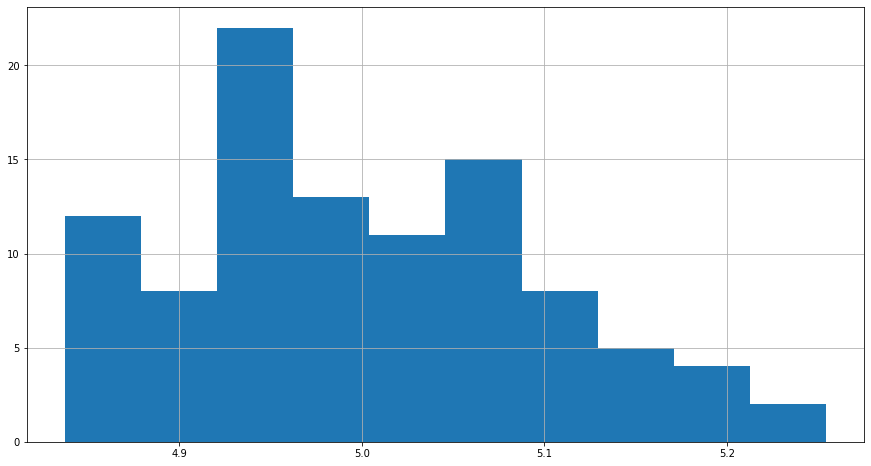

In [221]:
plt.figure(figsize=(15,8))
plt.grid()
plt.hist(samples)

## 2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwta, dystrybuantę, a też wartość oczekiwan, wariancję i funkcję kowariancyjną.

### Obliczenie gęstości prawdopodobieństwa

<font color=red>Uwaga aby wyświetlić gęstość prawdopodobieństwa należy posortować najpierw tablicę. Wytłumaczenie w linku poniżej</font>       
https://stackoverflow.com/questions/71296986/how-to-draw-the-probability-density-function-pdf-plot-in-python

Rozwiązanie 1

[1.06323765 1.10369759 1.11747992 1.31778689 1.41185046 1.4338672
 1.56718257 1.5939609  1.65083004 1.7287907  1.820073   1.83793544
 2.01279798 2.17117162 2.35963231 2.41935281 2.428505   2.56949491
 2.71114414 2.84311754 2.98057237 2.98272423 2.98951839 3.03244513
 3.07186999 3.08867129 3.1330196  3.17500232 3.22338567 3.28030785
 3.2847563  3.29450129 3.37864183 3.45515918 3.50652111 3.56829841
 3.61751724 3.62301479 3.67583817 3.68931628 3.69752691 3.70922176
 3.76544876 3.77548261 3.78152881 3.78907447 3.82464726 3.84296173
 3.90856402 3.91276201 3.92205858 3.97297738 3.97641088 3.98245855
 3.98873281 3.98132742 3.95089879 3.95081504 3.91529626 3.90141271
 3.86172709 3.81913562 3.78450026 3.73678092 3.60008579 3.59993906
 3.48008231 3.47662186 3.43207204 3.40185561 3.38382406 3.35495457
 3.24009891 3.23221088 3.11060843 3.0582507  2.9521733  2.86267344
 2.74537043 2.74184431 2.73781122 2.66648263 2.6402125  2.63769783
 2.61874443 2.35041093 2.32910426 2.22425362 1.89356952 1.56475

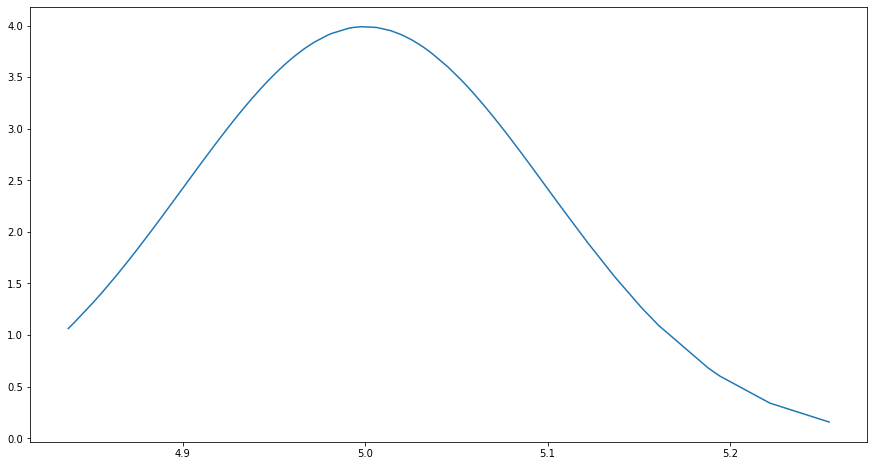

In [222]:
probability_pdf = norm.pdf(df["samples_value"].sort_values(), mu, sigma)
print(probability_pdf)

plt.figure(figsize=(15,8))
plt.plot(df["samples_value"].sort_values(), probability_pdf)

Rozwiązanie 2

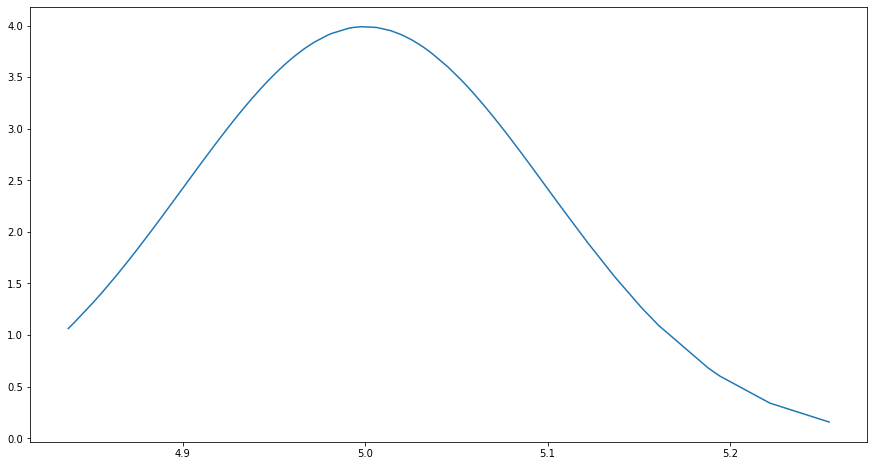

In [223]:
sort_samples = np.sort(samples)
probability_pdf = norm.pdf(sort_samples, mu, sigma)

plt.figure(figsize=(15,8))
plt.plot(sort_samples, probability_pdf)

### Obliczenie dystrybuanty

Podobnie jak dla obliczenia gęstości prawdopodobieństwa najpierw należało skorzystać z posortowanych wcześniej danych w tablicy <font color=yellow>samples</font>
https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python

(100,)


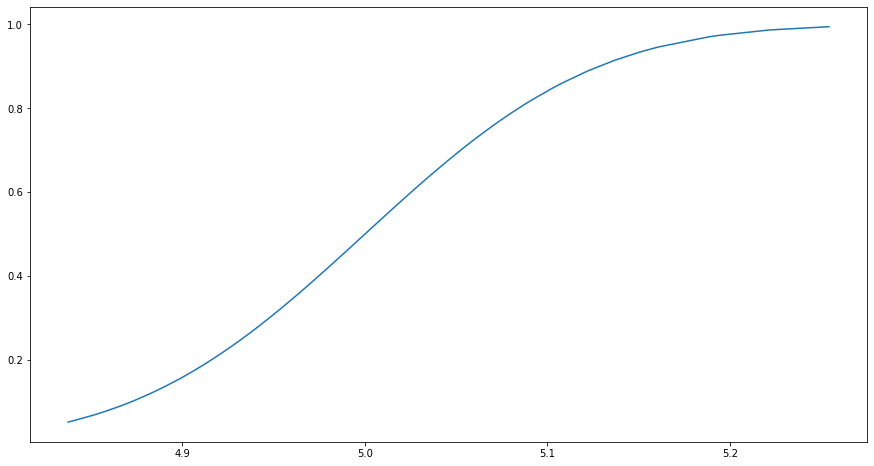

In [224]:
norm_cdf = norm.cdf(sort_samples, mu, sigma)
print(norm_cdf.shape)

plt.figure(figsize=(15,8))
plt.plot(sort_samples, norm_cdf)

### Obliczenie wartości oczekiwanej

Wytłumaczone na filmiku jak w pythonie obliczać wartość oczekiwaną oraz wariancję
https://www.youtube.com/watch?v=ikcUBqELZVU

In [225]:
expected_value = describe(samples).mean
print(expected_value)

5.0004722106389226


### Obliczenie wariancji

In [226]:
variance = describe(samples).variance
print(variance)

0.009551412366760409


### Obliczenie funkcji kowariancyjnej

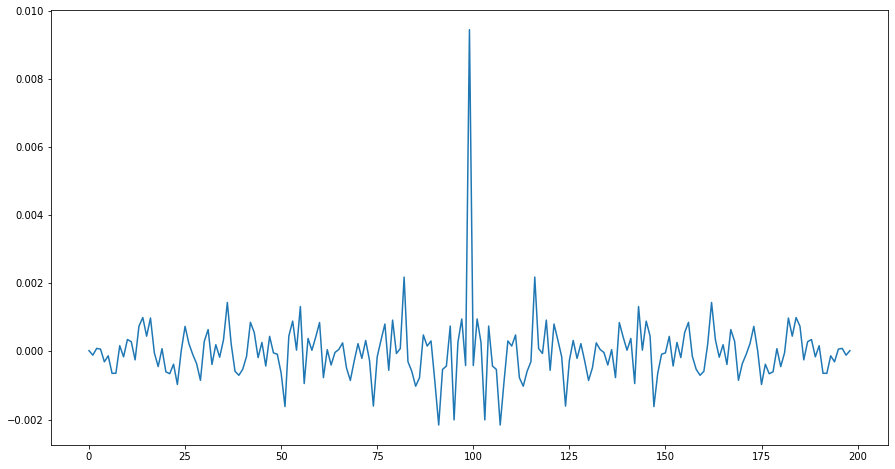

In [227]:
# Subtitute DC component noise signal from samples
subtitute_mu_value = samples - mu
# Compute covariance function
cov = np.correlate(subtitute_mu_value, subtitute_mu_value, mode='full') / num_samples

# Plot covariance function
plt.figure(figsize=(15,8))
plt.plot(cov)